In [1]:
import pandas as pd
from pandas import DataFrame
from datetime import date
import calendar
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cd = os.path.split(os.getcwd())[0]
if cd not in sys.path:
    sys.path.append(cd)

from lib import noaa, bexarcrime

# Hypotheses
## 1. Temperature is positively correlated with the violent crime rates (Richard)
## 2. Humidity and pressure have no impact on violent crime
## 3. Violent crime is higher in summer vs winter (Lalo)
## 4. Violent crime is higher during midnight hours (11:00pm - 2:00am) (Lexi)
## 5. Is there a spike in total crime at 2:00AM because bars close? (Laxo)

In [2]:
class City:
    """Class representing each city
    
    Attributes:
        name (str): Name of the city City, 2-letter State
        filepath (str): Filepath for the crime data
        isd_code (str): Code for NOAA's ISD. Composed of USAF-WBAN id
        dfc (DataFrame): Dataframe holding all crime data for the city
        dfv (DataFrame): Dataframe holding only violent crime for the city
        dfw (DataFrame): Dataframe holding weather data for the city
        df (Dataframe) : Dataframe holding the merged weather+violentcrime data
        all_crime (DataFrame): Alias for dfc
        violent_crime (DataFrame): Alias for dfv
        weather (Dataframe): Alias for dfw
        
    """
    
    def __init__(self, name, filepath, isd_code):
        self.name = name
        self.filepath = filepath
        self.isd_code = isd_code
    
    def load_crime(self, process=True):
        """Reads crime dataset from filepath and stores in dfc and dfv
        
        Args:
            process (bool): Whether to immediately or lazily process the data
                Defaults to true, process the data
        
        Returns:
            self
        """
        self.dfc = pd.read_csv(self.filepath, compression='gzip')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting', 'Arson'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        if process: 
            return self.process_crime()
        
        return self
    
    def process_crime(self, how='Fast'):
        """Processes the crime by converting the dates to datetime dtypes
        
        Args:
            how (str): How to process the crime. Fast method drops data that doesn't
                            specify the time of day, and is in general faster
                            
        Returns:
            self
            
        """
        if how == 'Fast':
            self.dfc.Time = pd.to_datetime(self.dfc.Time, 
                                           format='%m/%d/%y. %I:%M %p.', 
                                           errors='coerce').dropna()
            self.dfc = self.dfc[self.dfc.Time.notnull()]
        else:
            self.dfc.Time = pd.to_datetime(self.dfc.Time, errors='coerce')
            
        self.dfc = self.dfc.set_index('Time')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting', 'Arson'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        
        return self
        
    def load_weather(self, start=2016, end=2018):
        """Loads weather over FTP from NOAA's website into dfw
        
        Args:
            start (int): Start year 
            end (int): End year
            
        Returns:
            self
        
        """
        self.dfw = noaa.noaa_from_web(self.isd_code, start, end).fillna(method='backfill')
            
        # drop relative humididty 
        self.dfw = self.dfw.drop('RHPeriod', axis = 1)
        
        # replace null values
        self.dfw['Temperature'] = self.dfw['Temperature'].replace(9999,np.nan)
        self.dfw['Pressure'] = self.dfw['Pressure'].replace(99999,np.nan)
        self.dfw['Humidity'] = self.dfw['Humidity'].replace(999, np.nan)
        self.dfw['Sky'] = self.dfw['Sky'].replace([9,99], np.nan)
        
        # scale values back
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x/10)
        self.dfw['Pressure'] = self.dfw['Pressure'].map(lambda x : x/10)
        
        # map sky oktas to coverage percentages, roughly
        self.dfw['Sky'] = self.dfw['Sky'].map(lambda x : x/8)
        
        # convert C to F
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x * 9/5 + 32)
        self.weather = self.dfw
        
        return self
        
    def merge_dfs(self, start='2016-01-01', end='2017-01-01'):
        """Merges violent crime and weather into a single dataset, df, cut into a range
        
        Args:
            start (date string): Start date to cut
            end (date string): End date to cut to
            
        Returns:
            Self
        
        """
        self.df = self.dfw.join(self.dfv, how='outer')
        self.df = self.df.groupby( 
                        [self.df.index.year, 
                         self.df.index.month, 
                         self.df.index.day, 
                         self.df.index.hour]
                    ).agg ({   
                         'Temperature' : 'mean', 
                         'Pressure' : 'mean',
                         'Humidity' : 'mean',
                         'Sky' : 'mean',
                         'Crime' : 'count'}
                    ).reset_index().rename(columns={
                        'level_0':'year',
                        'level_1':'month',
                        'level_2':'day',
                        'level_3':'hour',
                    })
        s = pd.to_datetime(self.df[['year', 'month', 'day', 'hour']])
        self.df = self.df.set_index(s).drop(['year', 'month', 'day', 'hour'], 
                                    axis=1)
        
        self.df = self.df.loc[self.df.index > start]
        self.df = self.df.loc[self.df.index < end]

        return self

In [3]:
cities = {
    ##'Albany, GA': City('Albany, GA', '../data/crime_albany_ga.csv.gz', '722160-13869'),
    ## Not enough data for Albany
    'Baltimore, MD': City('Baltimore, MD', '../data/crime_baltimore_md.csv.gz', '745944-93784'),
    'Detroit, MI': City('Detroit, MI', '../data/crime_detroit_mi.csv.gz', '725375-14822'),
    'Flint, MI': City('Flint, MI', '../data/crime_flint_mi.csv.gz', '726370-14826'),
    'Memphis, TN': City('Memphis, TN', '../data/crime_memphis_tn.csv.gz', '723340-13893'),
    'Philadelphia, PA': City('Philadelphia, PA', '../data/crime_philadelphia_pa.csv.gz', '724080-13739'),
    ##'Pine Bluff AR': 
    ## no data for Pine Bluff
    'St. Louis, MO': City('St. Louis, MO', '../data/crime_st.+louis_mo.csv.gz', '725314-03960'),
    'Toledo, OH': City('Toledo, OH', '../data/crime_toledo_oh.csv.gz', '720275-04872')
}

In [ ]:
for city in cities.values():
    print(city.name)
    city.load_weather().load_crime().merge_dfs()
    df = city.df[['Temperature', 'Crime']].dropna()
    sns.jointplot(x='Temperature', y='Crime', data=df)
    plt.title(city.name)

Playing with times for baltimore and st louis

In [4]:
blt = cities['Baltimore, MD']
blt.load_crime().load_weather().merge_dfs()

In [ ]:
stl = cities['St. Louis, MO']
stl.load_crime().load_weather().merge_dfs()

In [ ]:
df = blt.df[['Temperature', 'Pressure', 'Humidity', 'Crime']]

In [ ]:
sns.pairplot(df.dropna())

In [ ]:
blt.dfc.Crime.value_counts().plot(kind='bar')

In [ ]:
stl.dfc.Crime.value_counts().plot(kind='bar')

In [ ]:
shooting = blt.dfc.where(blt.dfc.Crime == 'Shooting').dropna()

In [ ]:
shooting.groupby(shooting.index.hour).count().plot(kind='bar')

# Determine if Hypothesis number four is correct/incorrect for Baltimore, MD

In [ ]:
df = blt.dfv.between_time(start_time='23:00', end_time='23:59')
dff = blt.dfv.between_time(start_time = '00:01', end_time = '02:00')
df3 = blt.dfv.between_time(start_time = '02:00', end_time = '23:00')
df4 = blt.dfv.between_time(start_time = '00:01', end_time = '23:59')

In [ ]:
midHo = df.groupby(df.index.hour).count().sum() + dff.groupby(dff.index.hour).count().sum()
otherHo = df3.groupby(df3.index.hour).count().sum()

# Other Stuff

In [ ]:
df2 = stl.dfc.between_time(start_time='00:01', end_time='23:59')

In [ ]:
df2.where(df2.Crime == 'Theft').groupby(df2.index.hour).count().plot(kind='bar')

# Investigate Crime based on Day of the Week in Baltimore, MD

In [ ]:
# this is a hack
d = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday': 4 , 'Saturday' : 5, 'Sunday' : 6}

# Baltimore, MD
df4 = blt.dfv
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'b')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('Baltimore, MD Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()
# St. Louis, MO
df4 = stl.dfv
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'r')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('St. Louis, Mo Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()

# Determine if Hypothesis four is correct/incorrect for St. Louis, Mo and compare with Baltimore, MD

In [ ]:
df = stl.dfv.between_time(start_time='23:00', end_time='23:59')
df2 = stl.dfv.between_time(start_time = '00:01', end_time = '02:00')
df3 = stl.dfv.between_time(start_time = '02:00', end_time = '23:00')
df4 = stl.dfv.between_time(start_time = '00:01', end_time = '23:59')

In [ ]:
smidHo = df.groupby(df.index.hour).count().sum() + df2.groupby(df2.index.hour).count().sum()
sotherHo = df3.groupby(df3.index.hour).count().sum()
print("St. Louis Midnight Hours : {}, Baltimore Midnight Hours : {}".format(smidHo[0], midHo[0]))
print("St. Louis All Other Hours : {}, Blatimore All Other Hours : {}".format(sotherHo[0], otherHo[0]))

# Look for increase in all crimes from 1-3 am due to Bar Closure

In [ ]:
df = blt.dfc.between_time(start_time = '01:00', end_time = '03:00')
df2 = stl.dfc.between_time(start_time = '01:00', end_time = '03:00')
df.groupby(df.index.hour).count().plot(kind = 'bar', title = 'Baltimore, MD', color = 'g')
df2.groupby(df2.index.hour).count().plot(kind = 'bar', title = 'St. Louis, MO', color = 'y')

# Determine if there is a positive correlation between Temperature and Violent Crime for Balitmore, MD and St. Louis, MO

In [ ]:
df = blt.df[['Temperature', 'Pressure', 'Crime']] # get df
df.corr().plot(kind = 'box', title = 'Baltimore, MD') # create graph of corr
df.corr().plot(kind = 'bar', title = 'Baltimore, MD') # create graph of corr
df.corr().plot(kind = 'line', title = 'Baltimore, MD') # create graph of corr
print('Baltimore, MD', df.corr()) # print chart of corr
df2 = stl.df[['Temperature', 'Pressure', 'Crime']] # get df 
df2.corr().plot(kind = 'box', title = 'St. Louis, MO') # create graph of corr
df2.corr().plot(kind = 'bar', title = 'St. Louis, MO') # create graph of corr
df2.corr().plot(kind = 'line', title = 'St. Louis, MO') # create graph of corr
print('St. Louis, MO', df2.corr()) # print chart of corr

In [56]:
seasonalDFV = blt.dfv
springStar = 3
summerEnd = 9
fallStart = 10
fallWintMask = (seasonalDFV.index.month < 3) | (seasonalDFV.index.month > 10)
summerSprMask =(seasonalDFV.index.month > springStar) & (seasonalDFV.index.month < summerEnd)

winterDF = pd.DataFrame(seasonalDFV.loc[fallWintMask].Crime.value_counts())
summerDF = pd.DataFrame(seasonalDFV.loc[summerSprMask].Crime.value_counts())


In [126]:
winterDF = winterDF.rename(columns={'Crime':'Winter'})
summerDF = summerDF.rename(columns={'Crime':'Summer'})
winterDF.merge(summerDF, left_index=True, right_index=True,how='left')
crimesCountBySeason = winterDF.merge(summerDF, left_index=True, right_index=True,how='left')
crimesCountBySeason.index.name = 'Crime'
crimesCountBySeason.unstack().index

MultiIndex(levels=[['Winter', 'Summer'], ['Assault', 'Robbery', 'Shooting', 'Arson']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]],
           names=[None, 'Crime'])

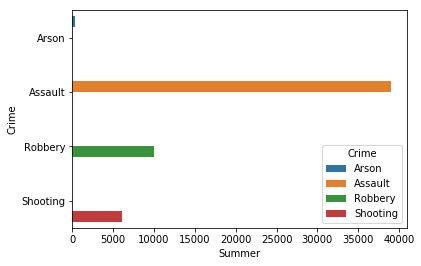

In [122]:
toAx = crimesCountBySeason.groupby(['Crime']).sum()[['Winter','Summer']]
ax = sns.barplot(x = toAx['Summer'], y=toAx.index, hue =toAx.index , data= toAx)

In [5]:
#d4.index

for value in blt.df.index:
    if(value.month is 12) or (value.month is 1) or (value.month is 2):
        month =calendar.month_name[value.month]
